In [1]:
import sys
sys.path.append("..")



from functools import partial

import matplotlib.pyplot as plt

import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from tqdm import trange
import tyxe

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

pyro.set_rng_seed(42)

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

In [7]:
X, y = make_circles(n_samples=5000, noise=0.1, factor=0.5)
X, y = make_moons(n_samples=5000, noise=0.1)
X, y = make_blobs(n_samples=1500, cluster_std=1, centers=2)

[]

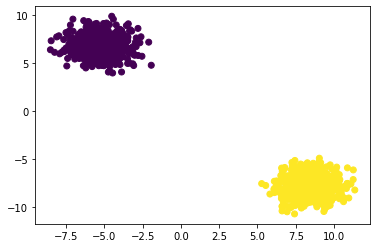

In [8]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot()

[]

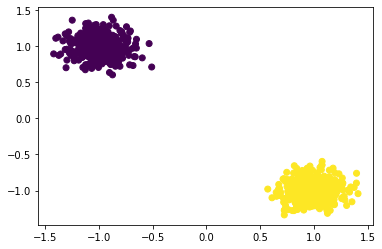

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=1000 , test_size=500)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float) 
X_test = torch.tensor(X_test, dtype=torch.float) 
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float) 
plt.scatter(X_train[:,0], X_train[:,1], c=y_train )
plt.plot()

In [10]:
batch_size = 50

In [11]:
dataset = data.TensorDataset(X_train, y_train )
loader = data.DataLoader(dataset, batch_size=batch_size)

In [33]:
net = nn.Sequential(
#     nn.Linear(2, 5),
#     nn.ReLU(inplace=True),
    nn.Linear(2, 1),
    nn.Sigmoid())
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.Bernoulli(batch_size, logit_predictions=False, event_dim=1)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.1)
# bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
bnn = tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel)

Sample: 100%|██████████████████████████████████████| 12000/12000 [05:11, 38.46it/s, step size=3.32e-01, acc. prob=0.697]                                                                    


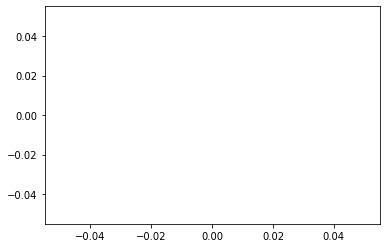

In [34]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    if i%100==0:
        print(e)
    print('.', end='')    
# with tyxe.poutine.local_reparameterization():
#     bnn.fit(loader, optim, 500, callback)
bnn.fit(loader, 10000, warmup_steps=2000)

plt.plot(elbos)
plt.show()

[]

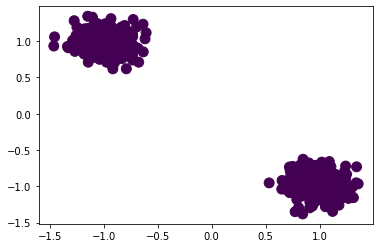

In [35]:
y_pred = bnn.predict(X_test, num_predictions=32, aggregate=False)
y_out = y_pred.squeeze().T
y_bay_test_proba = y_out.mean(axis=1)
sd = y_out.std(axis=1)

y_bay_test = y_bay_test_proba> 0.5

plt.scatter(X_test[:,0], X_test[:,1], c=y_bay_test>0.5, s=(1-sd*2)*100 )
plt.plot()

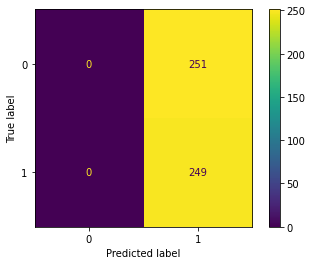

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       251
         1.0       0.50      1.00      0.66       249

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.33       500



c:\users\ruben menke\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ruben menke\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ruben menke\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [36]:
cm = confusion_matrix(y_test, y_bay_test)
ConfusionMatrixDisplay(cm).plot()
plt.show()
print(classification_report(y_test, y_bay_test))

In [37]:
# Deterministic net for comparission

det_net = nn.Sequential(
    nn.Linear(2, 5), 
    nn.ReLU(inplace=True), 
    nn.Linear(5, 1), 
    nn.Sigmoid())
optim = torch.optim.Adam(det_net.parameters(), 1e-4)
for _ in trange(200):
    optim.zero_grad()
    det_net(X_train).sub(y_train).pow(2).mean().backward()
    optim.step()




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.76it/s]


[]

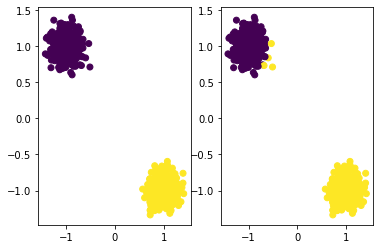

In [22]:
y_det_train_proba =  det_net(X_train).detach()
y_det_train = 1*(y_det_train_proba> 0.5)
plt.subplot(121)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train )

plt.subplot(122)
plt.scatter(X_train[:,0], X_train[:,1], c=y_det_train )
plt.plot()

[]

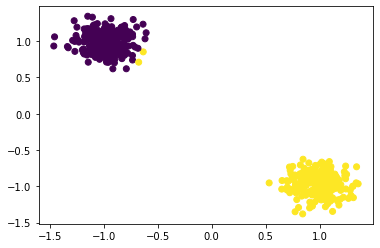

In [23]:
y_det_test_proba =  det_net(X_test).detach()
y_det_test = 1*(y_det_test_proba> 0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=y_det_test )
plt.plot()

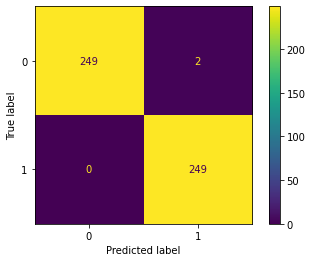

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       251
         1.0       0.99      1.00      1.00       249

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [24]:

cm = confusion_matrix(y_test, y_det_test)
ConfusionMatrixDisplay(cm).plot()
plt.show()
print(classification_report(y_test, y_det_test))